<a href="https://colab.research.google.com/github/sogand73/OCT-Classification/blob/main/without_dictionary_learning_for_OCT(Macular_Dataset_Heidelberg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from PIL import Image
import cv2
import shutil
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import MiniBatchDictionaryLearning
from joblib import dump, load

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 8.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Data preparing

In [3]:
!sudo apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [4]:
# Dataset collected from Macular Dataset Heidelberg --------> 600 train (100 validation), 200 test for each class
!unrar x '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/Dataset.rar'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/Dataset.rar

Creating    Dataset                                                   OK
Creating    Dataset/Test                                              OK
Creating    Dataset/Test/AMD                                          OK
Extracting  Dataset/Test/AMD/1.TIFF                                        0%  OK 
Extracting  Dataset/Test/AMD/100.TIFF                                      0%  OK 
Extracting  Dataset/Test/AMD/1000.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1018.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1021.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1022.TIFF                                     0%  OK 
Extracting  Dataset/Test/AMD/1026.TIFF                 

In [ ]:
#@title Classification using YOLOv8

In [5]:
shutil.rmtree('/content/oct_my_dataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_dataset'

In [6]:
import os
!mkdir '/content/oct_my_dataset'
!mkdir '/content/oct_my_dataset/Train'
!mkdir '/content/oct_my_dataset/Test'
!mkdir '/content/oct_my_dataset/Val'


In [7]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_dataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_dataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_dataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [8]:
import shutil


# Define source and destination directories
dataset_folder = '/content/Dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/'  # Replace with your destination folder path

#for folder in [['Train/',500], ['Test/',200], ['val/',100]]:
for folder in [['Train/',600], ['Test/',200]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            shutil.copy(source_path, destination_path)
            #print(f"Copied: {file_name}")


In [9]:
#Separate and store Val data from train data
# Define source and destination directories
dataset_folder = '/content/oct_my_dataset/Train/'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/Val/'  # Replace with your destination folder path



for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_copy = os.listdir(source_folder)

  # Copy each image file from the source folder to the destination folder
  for num in range(500,600):
    file_name = files_to_copy[num]
    if file_name.endswith('.TIFF'):  # Specify the image file formats
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, subfolder) + '/'
        shutil.copy(source_path, destination_path)
        #print(f"Copied: {file_name}")

In [10]:
shutil.rmtree('/content/oct_my_trdataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/oct_my_trdataset'

In [11]:
import os
!mkdir '/content/oct_my_trdataset'
!mkdir '/content/oct_my_trdataset/Train'
!mkdir '/content/oct_my_trdataset/Test'
!mkdir '/content/oct_my_trdataset/Val'

In [12]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_trdataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_trdataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_trdataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [13]:
import shutil


# Define source and destination directories
#dataset_folder = '/content/drive/MyDrive/oct_classification/oct_my_dataset'
dataset_folder = '/content/oct_my_dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_trdataset/'  # Replace with your destination folder path

for folder in [['Train/',500], ['Test/',200], ['Val/',100]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            #shutil.copy(source_path, destination_path)
            img = Image.open(source_path) # This returns an image object
            #print(img.mode)
            #img = img.convert('RGB')
            img = np.asarray(img) # convert it to ndarray
            img = cv2.resize(img, (512, 512))
            img = img.astype(float)
            img /= 255.0

            # # #Normalized data
            # img_tr -= np.mean(img_tr, axis=0)
            # img_tr /= np.std(img_tr, axis=0)

            img = img*255
            img_tr = img.astype(np.uint8)



            # Save the image to the specified directory
            save_destination = os.path.join(destination_path, file_name)
            #image_to_save.save(save_destination)
            cv2.imwrite(save_destination, img_tr)


            #images.append(img_tr2d)
            #print(f"Copied: {file_name}")


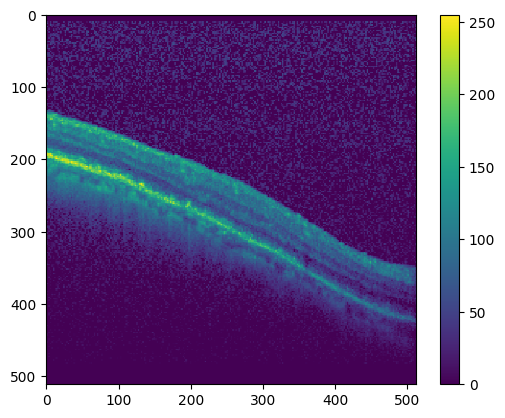

In [14]:
plt.imshow(img_tr, interpolation='nearest')
plt.colorbar()

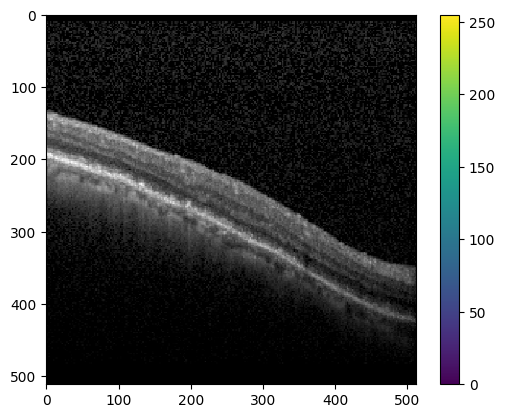

In [15]:
c = cv2.imread(save_destination)
plt.imshow(c, interpolation='nearest')
plt.colorbar()

In [1]:
from ultralytics import YOLO

# Load a model

#model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
#model = YOLO('/content/runs/classify/train2/weights/best.pt') #Load the initial weights, gained from the former model training on this data (previous line)

model = YOLO('yolov8n-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data='/content/oct_my_trdataset', epochs=10, imgsz=512, batch=64)

YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs
YOLOv8n-cls summary: 99 layers, 2719288 parameters, 2719288 gradients, 4.4 GFLOPs
Transferred 158/158 items from pretrained weights
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.yaml, data=/content/oct_my_trdataset, epochs=10, time=None, patience=50, batch=64, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False

train: Scanning /content/oct_my_trdataset/train... 1500 images, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]
val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/classify/train4
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all       0.56          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]

                   all      0.687          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.65it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.63it/s]

                   all      0.887          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.52it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      3.38G    0.08442         28        512: 100%|██████████| 24/24 [00:34<00:00,  1.45s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all      0.967          1



10 epochs completed in 0.108 hours.
Optimizer stripped from runs/classify/train4/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train4/weights/best.pt, 3.0MB

Validating runs/classify/train4/weights/best.pt...
Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1438723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 600 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


                   all      0.967          1
Speed: 0.5ms preprocess, 1.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train4
Results saved to runs/classify/train4


In [2]:
# Validate the modelblob:https://colab.research.google.com/f8428635-acf6-400f-b52f-379198002792
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy

Ultralytics YOLOv8.1.6 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1438723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 600 images in 3 classes ✅ 


val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


                   all      0.967          1
Speed: 0.4ms preprocess, 4.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train42


0.9666666984558105

In [ ]:
# @title Predict using the model



In [5]:
#test_score = model.predict(source='/content/oct_my_trdataset/test/Normal')
#0:AMD 1:DME 2:Normal
label_predict = []
label_conf = []
label_true = []

test_path = '/content/oct_my_trdataset/test/'

for subfolder in ['Normal', 'DME', 'AMD']:
  test_img_dir = os.path.join(test_path, subfolder)
  test_img = model(test_img_dir)

  for num in range(200):
    label_true.append(subfolder)
    label_predict.append(test_img[num].names[test_img[num].probs.top1])
    label_conf.append(test_img[num].probs.top1conf)

print(label_true)
print(label_predict)
print(label_conf)


image 1/200 /content/oct_my_trdataset/test/Normal/1.TIFF: 512x512 Normal 0.62, AMD 0.38, DME 0.00, 3.3ms
image 2/200 /content/oct_my_trdataset/test/Normal/100.TIFF: 512x512 Normal 0.68, DME 0.26, AMD 0.06, 3.5ms
image 3/200 /content/oct_my_trdataset/test/Normal/1001.TIFF: 512x512 Normal 0.93, AMD 0.05, DME 0.02, 3.1ms
image 4/200 /content/oct_my_trdataset/test/Normal/1013.TIFF: 512x512 Normal 0.99, DME 0.01, AMD 0.00, 3.1ms
image 5/200 /content/oct_my_trdataset/test/Normal/1019.TIFF: 512x512 Normal 1.00, AMD 0.00, DME 0.00, 3.0ms
image 6/200 /content/oct_my_trdataset/test/Normal/1020.TIFF: 512x512 Normal 0.99, AMD 0.00, DME 0.00, 3.0ms
image 7/200 /content/oct_my_trdataset/test/Normal/1024.TIFF: 512x512 Normal 0.99, DME 0.00, AMD 0.00, 3.1ms
image 8/200 /content/oct_my_trdataset/test/Normal/103.TIFF: 512x512 Normal 0.90, AMD 0.08, DME 0.02, 3.4ms
image 9/200 /content/oct_my_trdataset/test/Normal/1032.TIFF: 512x512 Normal 0.92, DME 0.07, AMD 0.01, 3.2ms
image 10/200 /content/oct_my_trd

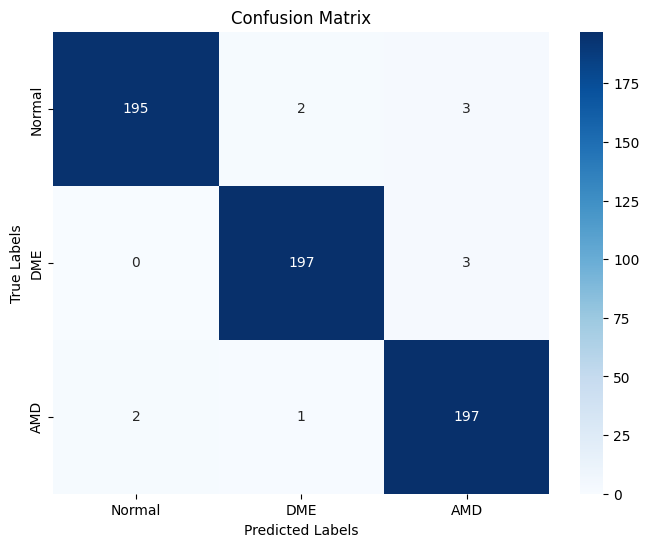

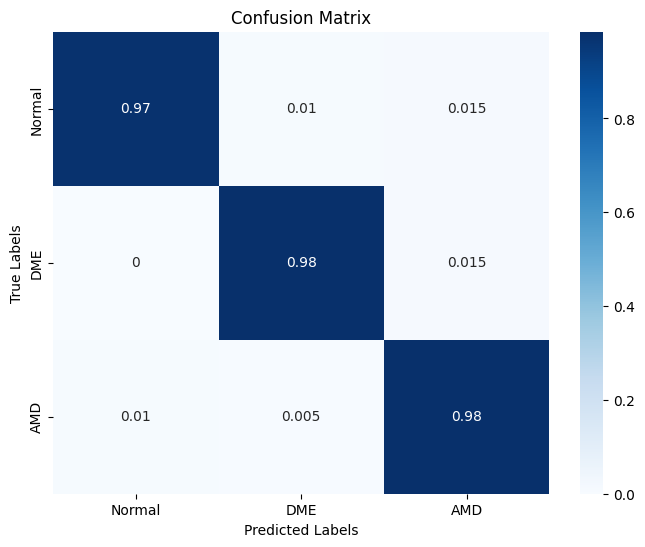

True

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


conf_matrix = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'])
conf_matrix_norm = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'], normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_image = np.array(heatmap.get_figure().canvas.renderer.buffer_rgba())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap_norm = sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_norm_image = np.array(heatmap_norm.get_figure().canvas.renderer.buffer_rgba())

cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix.jpeg', heatmap_image)
cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix_norm.jpeg', heatmap_norm_image)

In [ ]:
#@title Inference time calculation on the test data

In [2]:
import os
import datetime
import numpy as np
import cv2
!pip install ultralytics
from ultralytics import YOLO


model_classification = YOLO('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/runs/classify/train4/weights/best.pt') # build from YAML and transfer weights


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 6.3 MB/s eta 0:00:00


In [3]:
#Define an inference time function
def inference(img, model_classification):
  start_time = datetime.datetime.now()

  # your functions
  #data transforming using dictionary learning
  img = np.asarray(img) # convert it to ndarray
  img = cv2.resize(img, (512, 512))
  img = img.astype(float)
  img /= 255.0
  img_tr = img*255
  img_tr = img_tr.astype(np.uint8)

  #predict the class using YOLOv8
  classification_result = model_classification(img_tr)
  final_label = classification_result[0].names[classification_result[0].probs.top1]


  end_time = datetime.datetime.now()
  elapsed_time = end_time - start_time
  #print(f"{elapsed_time=}")

  return final_label, elapsed_time


In [4]:
#Images importing
from PIL import Image

img_list = []
dataset_folder = '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/oct_my_dataset/Test/'  # Replace with your source folder path
for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_open = os.listdir(source_folder)

  # Open each image file from the source folder
  for img_name in files_to_open[:10]:
    img_dir = os.path.join(source_folder, img_name)
    image = Image.open(img_dir) # This returns an image object
    img_list.append(image)

In [5]:
#Inference time calculation

label_list = []
inference_list = []
for img in img_list:
  label, time = inference(img, model_classification)
  label_list.append(label)
  inference_list.append(time)


0: 512x512 Normal 0.93, AMD 0.05, DME 0.02, 184.1ms
Speed: 43.8ms preprocess, 184.1ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal 0.99, AMD 0.01, DME 0.00, 61.8ms
Speed: 11.4ms preprocess, 61.8ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal 0.87, AMD 0.12, DME 0.01, 56.6ms
Speed: 10.9ms preprocess, 56.6ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal 0.99, AMD 0.01, DME 0.01, 61.0ms
Speed: 14.0ms preprocess, 61.0ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal 0.99, AMD 0.00, DME 0.00, 60.3ms
Speed: 13.3ms preprocess, 60.3ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal 1.00, AMD 0.00, DME 0.00, 60.4ms
Speed: 16.1ms preprocess, 60.4ms inference, 0.1ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 Normal 0.98, DME 0.01, AMD 0.01, 58.7ms
Speed: 11.7ms preprocess, 58.7ms inference, 0.

In [6]:
#print the inference time
inference_mean = np.mean(inference_list)
print(f"{inference_mean=}")

inference_mean=datetime.timedelta(microseconds=147489)


In [ ]:
#@title Save folders and experiments on the Google Drive

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dataset')

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset')

In [ ]:
#shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/runs')

In [13]:
#copy folders to google drive
shutil.copytree("/content/oct_my_dataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/oct_my_dataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/oct_my_dataset'

In [14]:
shutil.copytree("/content/oct_my_trdataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/oct_my_trdataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/oct_my_trdataset'

In [15]:
shutil.copytree("/content/runs", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/runs")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test11/runs'

In [ ]:
#@title More simpler YOLO implementation prompts

In [ ]:
#train
!yolo task=classify mode=predict model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' data='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset' epochs = 10 imgsz=512

In [ ]:
#validation
!yolo task=classify mode=val model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' data='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset'

In [ ]:
#prediction
!yolo task=classify mode=predict model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' source='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset/test/AMD' conf = 0.25

In [ ]:
#export
!yolo export model='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.pt' format = onnx

In [ ]:
#Download the model
from google.colab import files
files.download(='/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/test10/runs/classify/train2/weights/best.onnx')


In [ ]:
#@title Dictlearn tests - incomplete

In [ ]:
!git clone https://github.com/permfl/dictlearn.git /content/dictlearn

Cloning into '/content/dictlearn'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 152 (delta 1), reused 2 (delta 0), pack-reused 145
Receiving objects: 100% (152/152), 2.11 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
!pip install dictlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 1.1 MB/s eta 0:00:00


In [ ]:
%cd /content/dictlearn
!pip install --file requirements.txt

/content/dictlearn

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --file


In [ ]:
!python setup.py install

Installing dictlearn...
Compiling /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx because it changed.
Compiling /content/dictlearn/dictlearn/_dictlearn/hessian.pyx because it changed.
[1/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running install
/usr/local/lib/python3.10/dist-packag

In [ ]:
import dictlearn as dl
dictionary = dl.dct_dict(256, 8)

AttributeError: module 'dictlearn' has no attribute 'dct_dict'

In [ ]:
import dictlearn as dl
dl.
image = dl.imread('examples/images/house.png')
image_patches = dl.Patches(image, 8)
matrix = image_patches.patches
matrix.shape

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl

denoise = dl.Denoise('noisy_image.png')
denoised_image = denoise.train().denoise()
plt.imshow(denoised_image)
plt.show()

AttributeError: module 'dictlearn' has no attribute 'Denoise'

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [ ]:
!pip show dictlearn

Name: dictlearn
Version: 0.2.1
Summary: Dictionary Learning Toolbox
Home-page: https://gitlab.com/unibuc/graphomaly/dictionary-learning
Author: Paul Irofti, Denis Ilie-Ablachim, Bogdan Dumitrescu
Author-email: graphomaly@fmi.unibuc.ro
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, scipy
Required-by: 


In [ ]:
print(dir(dl))
dl.kernels()

['DictionaryLearning', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_dictionary_learning', '_get_fit_handle', 'dictionary_learning', 'kernel_dictionary_learning', 'kernels', 'methods', 'online_dictionary_learning', 'sparse_encode']


In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl
dl.
inpainter = dl.inpaint('image.png', 'mask.png')
inpainted_image = inpainter.train().inpaint()

plt.subplot(121)
plt.imshow(inpainter.patches.image)
plt.title('Original')

plt.subplot(122)
plt.imshow(inpainted_image)
plt.title('Inpainted')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'inpaint'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2


image = cv2.imread('images/vessel.png')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True, n_init=3)
patch_size = (30, 30)

buffer = []
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

Learning the dictionary... 
[MiniBatchKMeans] Reassigning 3 cluster centers.
Partial fit of  100 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
[MiniBatchKMeans] Reassigning 2 cluster centers.
Partial fit of  300 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  400 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Part

In [ ]:
a = faces.images

In [ ]:
a.dtype

dtype('float32')

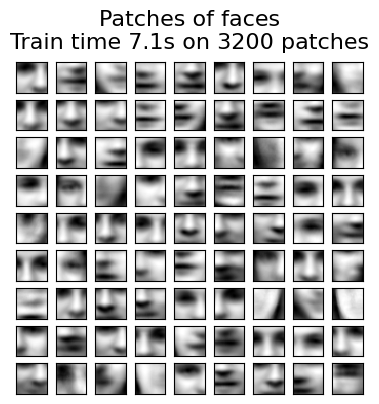

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()